In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #for GPU usage
#import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import callbacks, optimizers
from keras.utils import multi_gpu_model
import tensorflow as tf

import DataPreprocessing as DP
from matplotlib import pyplot as plt
from astropy.io import fits
#from skimage import exposure
#------------------------------------------------------------------------#
import time
Tstart = time.time() #Timer start


In [2]:
# 使用第一张与第三张GPU卡
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
#cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus)
tf.config.experimental.set_visible_devices(devices=gpus, device_type='XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [3]:
#norm spectrum
kinds = ['boss_cv','boss_da+ms','boss_db','boss_db+ms','boss_dq','boss_dz','fgkm','hotstars','wd','wdsb2','yso','hotstars_m']
flux_cv, spectrum_cv = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[0]+'/'+'*.fit')
flux_dams, spectrum_dams = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[1]+'/'+'*.fit')
flux_db, spectrum_db = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[2]+'/'+'*.fit')

In [4]:
#delate bad data
n = 0
for i in range(len(spectrum_db)):
    if len(spectrum_db[i][0]) < 4096:
        n = i
flux_db.pop(n)
spectrum_db.pop(n)

[array([5282.0195, 5283.235 , 5284.453 , 5285.669 , 5286.8877, 5288.104 ,
        5289.323 , 5290.54  , 5291.7573, 5292.9775, 5294.1953, 5295.416 ,
        5296.6343, 5297.8555, 5299.074 , 5300.2935, 5301.5156, 5302.7354,
        5303.958 , 5305.178 , 5306.4014, 5307.622 , 5308.8433, 5310.0674,
        5311.289 , 5312.5137, 5313.736 , 5314.9614, 5316.184 , 5317.407 ,
        5318.6333, 5319.857 , 5321.0835, 5322.3076, 5323.5347, 5324.76  ,
        5325.9844, 5327.213 , 5328.438 , 5329.667 , 5330.893 , 5332.122 ,
        5333.349 , 5334.5757, 5335.806 , 5337.0337, 5338.264 , 5339.492 ,
        5340.7236, 5341.952 , 5343.181 , 5344.413 , 5345.6426, 5346.8755,
        5348.1055, 5349.339 , 5350.5693, 5351.8003, 5353.034 , 5354.2656,
        5355.5005, 5356.7324, 5357.968 , 5359.2   , 5360.433 , 5361.6694,
        5362.903 , 5364.139 , 5365.3735, 5366.611 , 5367.845 , 5369.08  ,
        5370.3184, 5371.5537, 5372.7925, 5374.0283, 5375.2676, 5376.504 ,
        5377.744 , 5378.981 , 5380.218

In [5]:
#input spectrum
l_list =  flux_cv+flux_dams+flux_db
sl = []
for i in range(len(l_list)):
    sl.append(len(l_list[i]))
sl_min = np.min(sl)
X_train = []
for i in range(len(l_list)):
    X_train.append(l_list[i][0:sl_min])
size = 4552
#X_train = l_list
X_train = np.stack(X_train)
#X_train = X_train.reshape(len(X_train),size,1) #change the shape to NHWC for CAE input
X_train = X_train.reshape(len(X_train),size)
print(X_train.shape) #print information of training samples

(1214, 4552)


In [6]:
#input_spe = Input(shape=(4552,1))
input_spe = Input(shape=4552)

In [7]:
# x = Conv1D(256, 9, activation='relu', padding='same')(input_spe)#(4096,256)
# x = MaxPooling1D(2, padding='same')(x)#(2048,256)
# x = Conv1D(128, 8, activation='relu', padding='same')(x)#(2048,128)
# x = MaxPooling1D(2, padding='same')(x)#(1024,128)
# x = Conv1D(64, 7, activation='relu', padding='same')(x)#(1024,64)
# x = MaxPooling1D(2, padding='same')(x)#(512,64)
# x = Conv1D(32, 3, activation='relu', padding='same')(x)#(512,32)
# x = MaxPooling1D(2, padding='same')(x)#(256,32)
x = Conv1D(16, 3, activation='relu', padding='same')(input_spe)#(4552,16)
x = MaxPooling1D(8, padding='same')(x)#(569,16)
x = Conv1D(8, 3, activation='relu', padding='same')(x)#(569,8)
x = MaxPooling1D(8, padding='same')(x)#(72,8)

x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
encoded = Dense(units=96, activation='relu', name='embedding')(x)
x = Dense(units=128, activation='relu')(encoded)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=576, activation='relu')(x)
x = Reshape((72,8))(x)
x.shape

x = Conv1D(8, 3, activation='relu', padding='same')(x)#(72,8)
x = UpSampling1D(8)(x)#(576,8)
x = Conv1D(16, 3, activation='relu', padding='same')(x)#(576,16)
x = UpSampling1D(8)(x)#(4608,16)
# # x = Conv1D(32, 3, activation='relu', padding='same')(x)#
# # x = UpSampling1D(2)(x)#(512,32)
# # x = Conv1D(64, 7, activation='relu', padding='same')(x)#(512,64)
# # x = UpSampling1D(2)(x)#(1024,64)
# # x = Conv1D(128, 8, activation='relu', padding='same')(x)#(1024,128)
# # x = UpSampling1D(2)(x)#(2048,128)
# # x = Conv1D(256, 9, activation='relu', padding='same')(x)#(2048,256)
# # x = UpSampling1D(2)(x)#(4096,256)
decoded = Dense(1,activation='softmax')(x)

autoencoder = Model(input_spe, decoded)
#autoencoder = multi_gpu_model(input_spe, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])####loss function
#autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4552, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4552, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 569, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 569, 8)            392       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 8)             0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               147712

In [7]:
encoded = Dense(units=1024, activation='relu', name='embedding')(input_spe)
decoded = Dense(4552, activation='sigmoid')(encoded) 
autoencoder = Model(input_spe, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer_adam, loss='categorical_crossentropy',metrics=['accuracy'])####loss function
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4552)]            0         
_________________________________________________________________
embedding (Dense)            (None, 1024)              4662272   
_________________________________________________________________
dense (Dense)                (None, 4552)              4665800   
Total params: 9,328,072
Trainable params: 9,328,072
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
Nepochs = 100 #number of epochs for CAE training
tosavemodel = True #if save the trained CAE model
plot_reconstruction = True #if plot the reconstruction comparison
savename = 'AE_reconstruction' #setup if "tosavemodel=True" or "plot_reconstuction=True"

In [9]:
Tprocess0 = time.time()
print('\n', '## DATE PREPARATION RUNTIME:', Tprocess0-Tstart) #Timer

## MAIN ##
#training
H = autoencoder.fit(X_train, X_train,
                epochs=Nepochs,
                shuffle=True)

Tprocess1 = time.time()
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0) #Timer


 ## DATE PREPARATION RUNTIME: 42.59494233131409
Epoch 1/100
38/38 [==============================] - 0s 4ms/step - loss: 35013.6953 - accuracy: 0.0016
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 34378.2930 - accuracy: 0.0025
Epoch 3/100
38/38 [==============================] - 0s 4ms/step - loss: 33957.5664 - accuracy: 0.0000e+00
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 33819.5352 - accuracy: 0.0033
Epoch 5/100
38/38 [==============================] - 0s 4ms/step - loss: 33575.1680 - accuracy: 0.0041
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 33451.9102 - accuracy: 0.0082
Epoch 7/100
38/38 [==============================] - 0s 4ms/step - loss: 33365.1719 - accuracy: 0.0016
Epoch 8/100
38/38 [==============================] - 0s 4ms/step - loss: 33209.9688 - accuracy: 8.2372e-04
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 33037.9805 - accuracy: 8.2372e-04
Epoch 10/100

In [10]:
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0)


 ## AE TRAINING RUNTIME: 16.16127586364746


/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


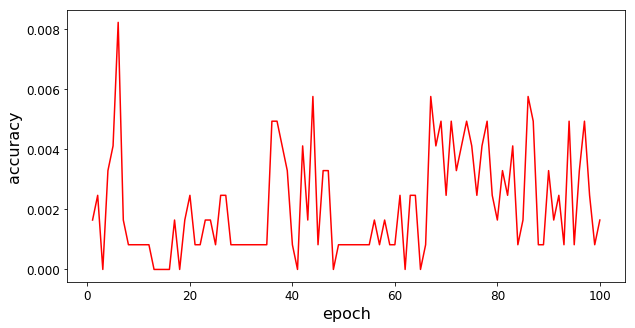

In [11]:
#plot loss function and accuracy function
acc = H.history['accuracy']
loss = H.history['loss']
plt.figure(figsize=[10,5])
font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size' : 16,
    }

epochs = range(1,Nepochs+1)
 
#plt.title('Accuracy')
plt.plot(epochs, acc,'red')
plt.xlabel('epoch',font2)
plt.ylabel('accuracy',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


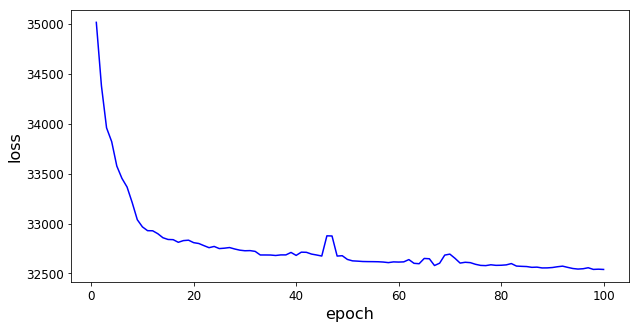

In [13]:
#plot loss function and accuracy function
 
#plt.title('Loss')
plt.figure(figsize=[10,5])
plt.plot(epochs, loss, 'blue')
plt.xlabel('epoch',font2)
plt.ylabel('loss',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

In [ ]:
if tosavemodel:
    #restore the model
    autoencoder.save(savename + '.h5')

if plot_reconstruction:
    #plot the results
    decoded_imgs = autoencoder.predict(X_train)

In [3]:
from keras.utils import multi_gpu_model

In [16]:
import tensorflow as tf
print (tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.2.0
Please install GPU version of TF


In [13]:
tf.config.experimental.list_physical_devices('XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [3]:
tf.debugging.set_log_device_placement(True)
 
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
 
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [15]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [18]:
import tensorflow as tf
print (tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.2.0
Please install GPU version of TF


In [4]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [3]:
import os

In [4]:
os.path

<module 'posixpath' from '/home/njl/anaconda3/lib/python3.7/posixpath.py'>

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  2


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [2]:
input_img = Input(shape=(101, 101, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(128, (8, 8), activation='relu', padding='same')(input_img) #(101, 101, 128)
x = MaxPooling2D((2, 2), padding='same')(x) #(51, 51, 128)
x = Conv2D(64, (7, 7), activation='relu', padding='same')(x) #(51, 51, 64)
x = MaxPooling2D((2, 2), padding='same')(x) #(26, 26, 64)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) #(26, 26, 32)
x = MaxPooling2D((2, 2), padding='same')(x) #(13, 13, 32)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #(13, 13, 16)
x = MaxPooling2D((2, 2), padding='same')(x) #(7, 7, 16)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) #(7, 7, 8)
x = MaxPooling2D((2, 2), padding='same')(x) #(4, 4, 8)

x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=32, activation='relu')(x)
encoded = Dense(units=24, activation='relu', name='embedding')(x)
x = Dense(units=32, activation='relu')(encoded)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Reshape((4, 4, 8))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x) #(4, 4, 8)
x = UpSampling2D((2, 2))(x) #(8, 8, 8)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) #(8, 8, 16)
x = UpSampling2D((2, 2))(x) #(16, 16, 16)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) #(16, 16, 32)
x = UpSampling2D((2, 2))(x) #(32, 32, 32)
x = Conv2D(64, (3, 3), activation='relu')(x) #(30, 30, 64)
x = UpSampling2D((2, 2))(x) #(60, 60, 64)
x = Conv2D(128, (7, 7), activation='relu')(x) #(54, 54, 128)
x = UpSampling2D((2, 2))(x) #(108, 108, 128)
decoded = Conv2D(1, (8, 8), activation='sigmoid')(x) #(101, 101, 1)

autoencoder = Model(input_img, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer_adam, loss='binary_crossentropy')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 128)     8320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        401472    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0     

In [5]:
autoencoder.layers[14].output

<tf.Tensor 'embedding/Identity:0' shape=(None, 24) dtype=float32>